In [46]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [47]:
df = pd.read_csv('car_price_prediction.csv')

In [48]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


Quick check for NaN values and duplicates.

In [49]:
# print out NaN values in each column
df.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [50]:
# print amount of duplicate rows
df.duplicated().sum()

313

In [51]:
# detele all duplicate rows
df.drop_duplicates(inplace=True)

In [52]:
# delete ID column, there is no any information there, only identificator
df.drop("ID", inplace=True,axis=1)

<h2>Levy</h2>
Levy in auto dealeship language could mean any additional fees, such as taxes and etc.

This column has "-" value in 30% of dataset, so I assume these mean not the NaN values, but the fact that there are no fees. So, I'll change them to zeroes.

In [53]:
df["Levy"].replace("-", "0", inplace=True)
# change data type of column to numeric
df["Levy"] = pd.to_numeric(df["Levy"])

/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_11989/2061335554.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Levy"].replace("-", "0", inplace=True)


<h2>Manufacturer, model</h2>
Manufacturer column has 65 distinct values. My first thought was to leave only let's say 10 mostly popular ones and bucket up everything else in "other" category. But then I had an idea to divide them into countries of origin, let's see if it works. 

I believe that it might work because most of the car brands in average consumer mind are related to country of origin and e.g. all korean or japanese cars are consider as reliable, or german cars well engineered. However I might loose some brands from premium or "very poor" segment. On the other hand they would possibly be outliers anyways, so...

ChatGPT was very usefull in this. Also I joined minority countries such as Georgia, Spain and Czech Republic into temporary "other" category which should be deleted afterwards. Model will automatically understand that if the car is not in any category, then it is "other".

In [54]:
df["Manufacturer"].unique()

array(['LEXUS', 'CHEVROLET', 'HONDA', 'FORD', 'HYUNDAI', 'TOYOTA',
       'MERCEDES-BENZ', 'OPEL', 'PORSCHE', 'BMW', 'JEEP', 'VOLKSWAGEN',
       'AUDI', 'RENAULT', 'NISSAN', 'SUBARU', 'DAEWOO', 'KIA',
       'MITSUBISHI', 'SSANGYONG', 'MAZDA', 'GMC', 'FIAT', 'INFINITI',
       'ALFA ROMEO', 'SUZUKI', 'ACURA', 'LINCOLN', 'VAZ', 'GAZ',
       'CITROEN', 'LAND ROVER', 'MINI', 'DODGE', 'CHRYSLER', 'JAGUAR',
       'ISUZU', 'SKODA', 'DAIHATSU', 'BUICK', 'TESLA', 'CADILLAC',
       'PEUGEOT', 'BENTLEY', 'VOLVO', 'სხვა', 'HAVAL', 'HUMMER', 'SCION',
       'UAZ', 'MERCURY', 'ZAZ', 'ROVER', 'SEAT', 'LANCIA', 'MOSKVICH',
       'MASERATI', 'FERRARI', 'SAAB', 'LAMBORGHINI', 'ROLLS-ROYCE',
       'PONTIAC', 'SATURN', 'ASTON MARTIN', 'GREATWALL'], dtype=object)

In [55]:
# dictionary with manufacters and origin countries according to ChatGPT
car_manufacturers = {
    "Japan": ['LEXUS', 'HONDA', 'TOYOTA', 'NISSAN', 'SUBARU', 'MITSUBISHI', 'MAZDA', 'SUZUKI', 'ACURA', 'ISUZU', 'DAIHATSU', 'INFINITI', 'SCION'],
    "USA": ['CHEVROLET', 'FORD', 'JEEP', 'GMC', 'LINCOLN', 'DODGE', 'CHRYSLER', 'TESLA', 'BUICK', 'CADILLAC', 'HUMMER', 'MERCURY', 'PONTIAC', 'SATURN'],
    "South Korea": ['HYUNDAI', 'KIA', 'DAEWOO', 'SSANGYONG'],
    "Germany": ['MERCEDES-BENZ', 'OPEL', 'PORSCHE', 'BMW', 'VOLKSWAGEN', 'AUDI'],
    "France": ['RENAULT', 'CITROEN', 'PEUGEOT'],
    "UK": ['LAND ROVER', 'MINI', 'JAGUAR', 'BENTLEY', 'ROLLS-ROYCE', 'ROVER', 'ASTON MARTIN', 'MG'],
    "Italy": ['FIAT', 'ALFA ROMEO', 'LANCIA', 'MASERATI', 'FERRARI', 'LAMBORGHINI'],
    "Sweden": ['VOLVO', 'SAAB'],
    "Russia": ['VAZ', 'GAZ', 'UAZ', 'MOSKVICH', 'ZAZ'],
    "China": ['HAVAL', 'GREATWALL'],
    "Other": ['SKODA', 'სხვა', 'SEAT']
}

In [56]:
# Now map a country to each manufacturer

# empty dictionary to store the mappings
manufacturer_to_country = {}

# Loop over each country and its list of manufacturers
for country, manufacturers in car_manufacturers.items():
    # For each manufacturer in the list, assign the country as the value
    for manufacturer in manufacturers:
        manufacturer_to_country[manufacturer] = country

# Now, 'manufacturer_to_country' maps each manufacturer to its corresponding country
print(manufacturer_to_country)

{'LEXUS': 'Japan', 'HONDA': 'Japan', 'TOYOTA': 'Japan', 'NISSAN': 'Japan', 'SUBARU': 'Japan', 'MITSUBISHI': 'Japan', 'MAZDA': 'Japan', 'SUZUKI': 'Japan', 'ACURA': 'Japan', 'ISUZU': 'Japan', 'DAIHATSU': 'Japan', 'INFINITI': 'Japan', 'SCION': 'Japan', 'CHEVROLET': 'USA', 'FORD': 'USA', 'JEEP': 'USA', 'GMC': 'USA', 'LINCOLN': 'USA', 'DODGE': 'USA', 'CHRYSLER': 'USA', 'TESLA': 'USA', 'BUICK': 'USA', 'CADILLAC': 'USA', 'HUMMER': 'USA', 'MERCURY': 'USA', 'PONTIAC': 'USA', 'SATURN': 'USA', 'HYUNDAI': 'South Korea', 'KIA': 'South Korea', 'DAEWOO': 'South Korea', 'SSANGYONG': 'South Korea', 'MERCEDES-BENZ': 'Germany', 'OPEL': 'Germany', 'PORSCHE': 'Germany', 'BMW': 'Germany', 'VOLKSWAGEN': 'Germany', 'AUDI': 'Germany', 'RENAULT': 'France', 'CITROEN': 'France', 'PEUGEOT': 'France', 'LAND ROVER': 'UK', 'MINI': 'UK', 'JAGUAR': 'UK', 'BENTLEY': 'UK', 'ROLLS-ROYCE': 'UK', 'ROVER': 'UK', 'ASTON MARTIN': 'UK', 'MG': 'UK', 'FIAT': 'Italy', 'ALFA ROMEO': 'Italy', 'LANCIA': 'Italy', 'MASERATI': 'Italy', 

In [57]:
# Create new column for country of origin and map it based on manufacturer
df['Country'] = df['Manufacturer'].map(manufacturer_to_country)

In [58]:
# encode categorical column into seperate features
variable = 'Country'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

In [59]:
# Finally drop the manufacturer column, model, "other".
# Model column has almost 1600 distinct values and is basically just a name for the car, pretty similar to ID column
# I think there is no way to get any information out of model

df.drop(["Manufacturer", "Model", "Other"], axis=1, inplace=True)

<h2>Category</h2>

Here I would like to join the cabriolet and coupe categories because cabriolet is basically coupe without roof.
Limousine category will be deleted before encoding for the same reason as "other" column previously.

In [60]:
df["Category"].value_counts()

Category
Sedan          8600
Jeep           5378
Hatchback      2799
Minivan         633
Coupe           528
Universal       361
Microbus        299
Goods wagon     229
Pickup           51
Cabriolet        35
Limousine        11
Name: count, dtype: int64

In [61]:
# Replace cabriolet to coupe
df["Category"].replace("Cabriolet", "Coupe", inplace=True)

/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_11989/487454773.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Category"].replace("Cabriolet", "Coupe", inplace=True)


In [62]:
# encode categorical column into seperate features
variable = 'Category'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

In [63]:
# Drop limousine to decrease multidimensionality
df.drop("Limousine", axis=1, inplace=True)

<h2>Leather interior</h2>
This one is simple, it's yes or no column so just encode it to binary. 

In [64]:
variable = 'Leather interior'

# NOTE: factorize can mix up the order of the values
values1, names1 = pd.factorize(df[variable], sort=False)
df[variable] = values1

<h2>Fuel type</h2>
I think about joining the plug in hybrid and hybrid into one category, they are slightly different but however
Also I think I'll delete row with hydrogen fuel type.

In [65]:
df["Fuel type"].value_counts()

Fuel type
Petrol            9944
Diesel            4001
Hybrid            3539
LPG                885
CNG                469
Plug-in Hybrid      85
Hydrogen             1
Name: count, dtype: int64

In [66]:
# search for the index of the row with fuel type hydrogen
i = df[df["Fuel type"] == "Hydrogen"].index
# Drop the hydrogen
df.drop(i, inplace=True)


In [67]:
# join hybrids
df.replace("Plug-in Hybrid", "Hybrid", inplace=True)

In [68]:
# Encode column and drop CNG to decrease column amount
variable = 'Fuel type'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

In [69]:
df.drop("CNG", axis=1, inplace=True)

<h2>Engine volume</h2>

Engine volume consist of float number indicating volume and sometimes also mention if it is turbo or not. 

I can extract volume and seperate turbo feature to different column

In [70]:
# separate number and Turbo
def process_engine(engine_value):
    # Extract the numeric part using regex
    # \d means any number between 0-9
    number = re.search(r'\d+\.\d+|\d+', engine_value)
    # save our extracted float
    number = float(number.group())

    # Check if "Turbo" is in the string
    turbo = 1 if "Turbo" in engine_value else 0

    return number, turbo

# Apply the function to the DataFrame
df[['Engine volume int', 'Turbo']] = df['Engine volume'].apply(lambda x: pd.Series(process_engine(x)))

# Drop the old Engine column
df.drop('Engine volume', axis=1, inplace=True)


<h2>Mileage</h2>
Mileage values are strings and contain "km".

In [71]:
# using regex exctract only numeric values
df['Mileage'].replace(r'[^0-9]+', '', regex=True, inplace=True)
# change data type of column to numeric
df["Mileage"] = pd.to_numeric(df["Mileage"])

/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_11989/3909022585.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Mileage'].replace(r'[^0-9]+', '', regex=True, inplace=True)


<h2>Gear box type</h2>
Same as other categorical variables

In [72]:
# Encode column and drop last feature to decrease column amount
variable = 'Gear box type'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

df.drop("Tiptronic", axis=1, inplace=True)


<h2>Drive wheels</h2>
Same as previous

In [73]:
# Encode column and drop last feature to decrease column amount
variable = 'Drive wheels'
dummies = pd.get_dummies(df[variable]).astype(int)
df = pd.concat([df, dummies], axis=1).drop(columns=variable)

df.drop("Rear", axis=1, inplace=True)

<h2>Doors</h2>
Column is in wrong format, I assume the real meaning is 4-5 (May is 5th month) for the most part of the cars, 2-3 (March is 3rd) for coupes and >5 for cars with more than 5 doors. 

However, basically amount of doors is same thing as type of car, most of the cars are sedans, universals or hatchabacks and they all have 4 to 5 doors. Cabriolets, coupes, pickups and good wagons have 2 to 3 doors. Buses have more than 5.

Another problem is that this column is very unbalanced, since owerhelming amount of cars have 4-5 doors.


So in this case I assume that is better to drop this column.

In [74]:
df["Doors"].value_counts()

Doors
04-May    18031
02-Mar      768
>5          124
Name: count, dtype: int64

In [75]:
df.drop("Doors", axis=1, inplace=True)

<h2>Wheel</h2>
Defines if the wheel is on right or left side. Binary caregory

In [76]:
variable = 'Wheel'

# NOTE: factorize can mix up the order of the values
values1, names1 = pd.factorize(df[variable], sort=False)
df[variable] = values1

<h2>Color</h2>

Color could be meaningfull for example for luxury cars, may be some kind of rare color combinations and so on. 

Also, when buying a new car in case you want any specific and dealership doesn't have it at the moment you have to wait for it.

But in general I don't think that the color has some significant influence on price, especially on used car market.

In [77]:
df.drop("Color", axis=1, inplace=True)

<h2>Splitting dataset</h2>

In [78]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
X = df.drop("Price", axis=1)

# have only the target variable here (dependent variable)
y = df['Price']

In [79]:
# Split 70% for training and 30% for testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the testing data, half for validation and half for testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<h2>Building model</h2>

<h2>Training</h2>

In [82]:
# pip install keras-tuner
import keras_tuner

def build_model(hp):
    # iniatlize sequential test neural network
    model = keras.Sequential()

    # first layer, batch normalization + input shape, same as in typical neural network
    model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    
    # add the first actual layer including the regularizer
    model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_0", min_value=32, max_value=86, step=4),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(l1=0.1)
        )
    )
        
    # automate a dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.1))

    # try additional layers, 1 or 2 extra layers
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i + 1}", min_value=4, max_value=64, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # output layer, only one node since this is regression
    model.add(layers.Dense(1))

    # automate learning rate tests
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # compile the test neural network
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse"
    )

    return model


# build the model + use RandomSearch to actually search the best options for our neural network
build_model(keras_tuner.HyperParameters())

# use val_loss as the objective, because regression tasks do not have accuracy
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="optimizations",
    project_name="regression1test",
)

# start searching
tuner.search(X_train, y_train, epochs=250, validation_data=(X_val, y_val))

Trial 5 Complete [00h 03m 04s]
val_loss: 243823766186.66666

Best val_loss So Far: 243720421376.0
Total elapsed time: 00h 15m 22s


In [83]:
tuner.results_summary()

Results summary
Results in optimizations/regression1test
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units_0: 36
activation: relu
dropout: True
num_layers: 2
units_1: 40
lr: 0.00035130677235196815
units_2: 28
Score: 243720421376.0

Trial 4 summary
Hyperparameters:
units_0: 84
activation: relu
dropout: True
num_layers: 2
units_1: 16
lr: 0.0011282276362648358
units_2: 16
Score: 243823766186.66666

Trial 3 summary
Hyperparameters:
units_0: 64
activation: relu
dropout: False
num_layers: 2
units_1: 28
lr: 0.00011894173793507069
units_2: 4
Score: 243879428096.0

Trial 2 summary
Hyperparameters:
units_0: 52
activation: relu
dropout: False
num_layers: 1
units_1: 12
lr: 0.00017955858969577045
units_2: 56
Score: 243894561450.66666

Trial 0 summary
Hyperparameters:
units_0: 52
activation: relu
dropout: False
num_layers: 2
units_1: 64
lr: 0.0007538603502895294
units_2: 4
Score: 244004929536.0


In [84]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/Users/kirillsobolev/Documents/GitHub/.venv/lib/python3.9/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kirillsobolev/Documents/GitHub/.venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 37)             │           148 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36)             │         1,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         1,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         1,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,173 (16.30 KB)

 Trainable params: 4,099 (16.01 KB)

 Non-trainable params: 74 (296.00 B)

In [105]:
model = keras.Sequential(
    [
        #layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(64, activation="relu", input_shape=(len(X.columns),)),
        layers.Dropout(rate=0.1),
        layers.Dense(40, activation="relu"),
        layers.Dense(28, activation="relu"),
        layers.Dense(1)
    ]
)

# optimal learning rate from keras tuner
optimal_lr = 0.00035130677235196815

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='mse')
# print out the summary of your model
model.summary()

/Users/kirillsobolev/Documents/GitHub/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 40)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 28)             │         1,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,209 (24.25 KB)

 Trainable params: 6,209 (24.25 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val))

Epoch 1/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step - loss: 1459904053248.0000 - val_loss: 1305845563392.0000
Epoch 2/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 2466057027584.0000 - val_loss: 442892582912.0000
Epoch 3/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 2628943609856.0000 - val_loss: 648394309632.0000
Epoch 4/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 542529257472.0000 - val_loss: 1268909211648.0000
Epoch 5/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 1739258068992.0000 - val_loss: 1128478408704.0000
Epoch 6/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 1343515787264.0000 - val_loss: 246919823360.0000
Epoch 7/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 176274751488.0000 - val_loss: 244434026496.0000
Epoch 8/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 302123057152.0000 - val_loss: 1954872426496.0000
Epoch 9/1200
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 1171472515072.0000 - val_loss: 

<h2>Metrics</h2>

<Axes: >

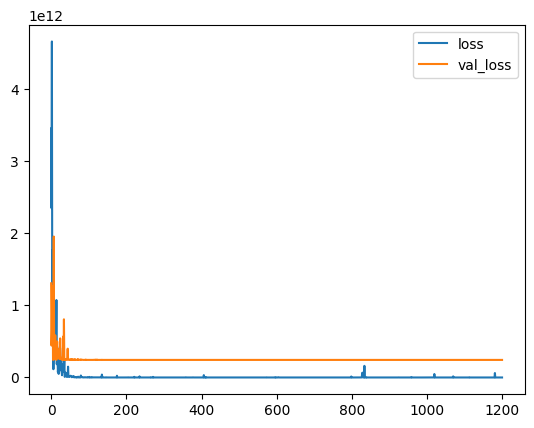

In [107]:
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# other notes:
# if your validation loss is fluctuating a lot, the test data set
# might not be a good sample / representation of the whole dataset
# try to get more data or try shuffling the dataset for a better sample
# if your validation loss FLUCTUATES EXTREMELY: remember to create 
# the neural network again completely (Sequential etc.), otherwise you might fit your 
# model to your previous model version weights

# we'll also study later methods on how to select the best epoch from 
# the training history

# a common reason why a numeric neural network for regression might overfit
# is that you might have too many variables but too little data

In [108]:
# compare test error values to training error values
# the model is often good when these error values are similar
# even if you training metrics above didn't overlap
# you might still get very close values in evaluation => more important

# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
293164960.0

Train data evaluation:
256372144.0


In [109]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


,Test True Y,Model Predictions
0,30784,19755.798828
1,17876,12713.877930
2,16308,11853.607422
3,7200,16118.701172
4,11604,11092.750000
...,...,...
2834,44724,20062.636719
2835,19416,14407.327148
2836,8500,13503.128906
2837,6743,11976.833008


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

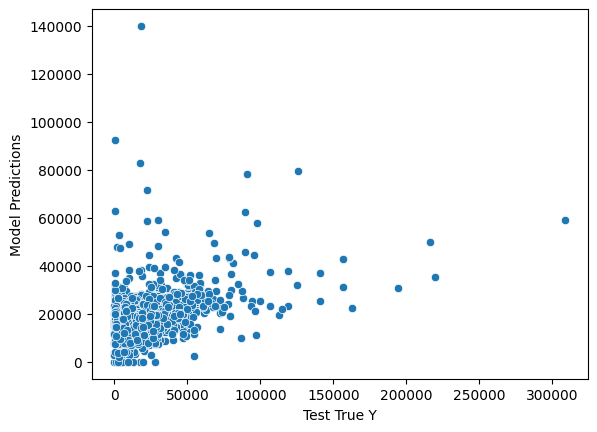

In [110]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [103]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
10531.88 $

MSE
290634135.34 $^2

RMSE:
17048.0 $

R-squared:
0.22

Explained variance score:
0.22


/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_11989/3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


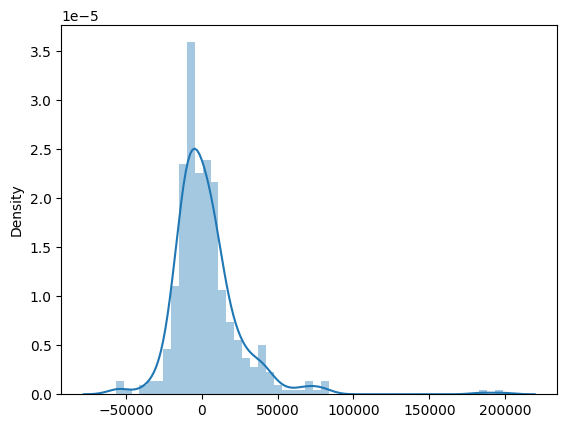

In [104]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()